## Imports

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from tensorflow.python.client import device_lib
from keras.models import Model
import boto3
from time import time
import os
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
import csv

## Classes to handle dataset images

In [8]:
class DatasetHandler(ABC):
    def __init__(self,
                 model_path,
                 obstacle_dataset,
                 no_obstacle_dataset,
                 img_width=200,
                 img_height=200,
                 batch_size=32,
                 rand_images=True,
                 num_rand_images=10,
                 thresh_csv_fname=None,
                 metrics_csv_fname=None):
        
        self.model_path = model_path
        self.obstacle_dataset = obstacle_dataset
        self.no_obstacle_dataset = no_obstacle_dataset
        self.dataset = '/'.join(self.obstacle_dataset.split('/')[:-1])
        self.img_width = img_width
        self.img_height = img_height
        self.obstacle_images = []
        self.no_obstacle_images = []
        self._update_image_lists = True
        self.rand_images = rand_images
        
        if rand_images:
            self.batch_size = min(batch_size, num_rand_images*2)
        else:
            self.batch_size = batch_size
            
        if rand_images:
            self.num_rand_images = num_rand_images
            self.num_obstacles = num_rand_images
            self.num_no_obstacles = num_rand_images
            self.num_images = num_rand_images*2
        else:
            # Will be determined while reading all images from dataset
            self.num_obstacles = 0
            self.num_no_obstacles = 0
            self.num_images = 0
            
        if rand_images:
            self.obstacle_image_names = self._get_random_dataset_image_names(self.obstacle_dataset)
            self.no_obstacle_image_names = self._get_random_dataset_image_names(self.no_obstacle_dataset)
        else:
            (self.obstacle_image_names,
            self.num_obstacles) = self._get_all_dataset_image_names(self.obstacle_dataset)
            (self.no_obstacle_image_names,
            self.num_no_obstacles) = self._get_all_dataset_image_names(self.no_obstacle_dataset)
            
        self.model_score = ModelScore()
            
        if thresh_csv_fname:
            thresh_csv_path = os.path.join(model_path, thresh_csv_fname)
            self.f_thresh_csv = open(thresh_csv_path, 'w')
            self.thresh_csv_writer = csv.writer(self.f_thresh_csv)
            
            self.thresh_csv_header = ['model',
                                      'dataset',
                                      'Max Lost Ratio',
                                      'Lower Threshold',
                                      'Upper Threshold',
                                      'Total Predictions',
                                      'TP',
                                      '% TP',
                                      'TN',
                                      '% TN',
                                      'FP',
                                      '% FP',
                                      'FN',
                                      '% FN',
                                      'Not Decided',
                                      '% Not Decided',
                                      'True Not Decided',
                                      '% True Not Decided']
            
            self.thresh_csv_writer.writerow(self.thresh_csv_header)
            
        if metrics_csv_fname:
            metrics_csv_path = os.path.join(model_path, metrics_csv_fname)
            self.f_metrics_csv = open(metrics_csv_path, 'w')
            self.metrics_csv_writer = csv.writer(self.f_metrics_csv)

            metrics_prefixes = ['test', 'validation', '']
            metrics_separators = [' ', ' ', '']
            metrics_functions = ['auc', 'recall', 'specifity']
            
            self.metrics_csv_header = ['Trial Name']
            self.metrics_csv_header.append('Model Score')
            self.metrics_csv_header.append('Lost True Values %')
            self.metrics_csv_header.append('Lower Threshold')
            self.metrics_csv_header.append('Upper Threshold')
            self.metrics_csv_header.append('% FP')
            self.metrics_csv_header.append('% FN')
            
            for i, metrics_prefix in enumerate(metrics_prefixes):
                for metrics_function in metrics_functions:
                    metric_name = metrics_separators[i].join([metrics_prefix, metrics_function])
                    self.metrics_csv_header.append('max ' + metric_name)
            
            self.metrics_csv_writer.writerow(self.metrics_csv_header)

    def write_csv(self, **args):        
        row = []
        keys = args.keys()
        
        if 'model' in keys:
            row.append(args['model'])
            
        row.append(self.dataset)
        
        for col in self.thresh_csv_header[2:]:
            if col in keys:
                row.append(args[col])
            else:
                row.append(None)
        
        self.thresh_csv_writer.writerow(row)
                
    @abstractmethod
    def _get_random_dataset_image_names(self, dataset):
        pass
    
    @abstractmethod
    def _get_all_dataset_image_names(self, dataset):
        pass
    
    @abstractmethod
    def _get_image(self, imname):
        pass
    
    def _preprocess_image(self, im):
        w = im.shape[1]
        im1 = im[:,:w//2]
        im2 = im[:,w//2:]
        sub = cv2.subtract(im1, im2)
        sub = sub.reshape(sub.shape[0], sub.shape[1], 1)
        arr = keras.preprocessing.image.smart_resize(sub,
                                                     (self.img_height, self.img_width),
                                                     interpolation='bilinear')
        arr /= 255.0
        return arr
    
    def image_generator(self):
        inputs = []
        outputs = [0]*self.num_no_obstacles + [1]*self.num_obstacles

        for image_name in tqdm(self.no_obstacle_image_names):
            im = self._get_image(image_name)
            if self._update_image_lists:
                self.no_obstacle_images.append(im)
            im = self._preprocess_image(im)
            inputs.append(im)

        for image_name in tqdm(self.obstacle_image_names):
            im = self._get_image(image_name)
            if self._update_image_lists:
                self.obstacle_images.append(im)
            im = self._preprocess_image(im)
            inputs.append(im)
            
        self._update_image_lists = False

        for i in range(0, self.num_images, self.batch_size):
            x = np.array(inputs[i:i+self.batch_size])
            y = np.array(outputs[i:i+self.batch_size])
            yield(x, y)
            
    @abstractmethod
    def get_metrics(self, model):
        pass
    
    @abstractmethod
    def get_predictions(self, model):
        pass
    
    def print_model_metrics(self, model):
        metrics = self.get_metrics(model)

        for name, value in zip(model.metrics_names, metrics):
            print(name, ': ', value)
            
    # Compute and plot confusion-matrix (TP, FP, TN, FN)
    def plot_cm(self,
                model_path,
                labels,
                predictions,
                p=0.5,
                max_lost_ratio=0,
                not_decided=0,
                trues=0,
                true_not_decided=0,
                lower_threshold=None,
                upper_threshold=None,
                print_to_csv=False):
    
        cm = confusion_matrix(labels, predictions > p)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, annot=True, fmt="d")
        if max_lost_ratio:
            plt.title('Confusion matrix @ max lost ratio {:.2f}'.format(max_lost_ratio))
        else:
            plt.title('Confusion matrix @ threshold {:.2f}'.format(p))
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        predicts = sum(sum(x) for x in cm)
        tot_predicts = predicts + not_decided
        
        TN = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TP = cm[1][1]
        
        TN_percent = (TN/tot_predicts)*100
        FP_percent = (FP/tot_predicts)*100
        FN_percent = (FN/tot_predicts)*100
        TP_percent = (TP/tot_predicts)*100
        not_decided_percent = (not_decided/tot_predicts)*100
        true_not_decided_percent = (true_not_decided/trues)*100

        print()
        if max_lost_ratio:
            print(f'Max Lost Ratio: {max_lost_ratio}')
        print(f'No Obstacles Detected (True Negatives): {TN} ({TN_percent:.2f}%)')
        print(f'No Obstacles Incorrectly Detected (False Positives): {FP} ({FP_percent:.2f}%)')
        print(f'Obstacles Missed (False Negatives): {FN} ({FN_percent:.2f}%)')
        print(f'Obstacles Detected (True Positives): {TP} ({TP_percent:.2f}%)')
        if not_decided:
            print(f'Not Decided: {not_decided} ({not_decided_percent:.2f}%)')
        if true_not_decided:
            print(f'True Not Decided: {true_not_decided} ({true_not_decided_percent:.2f}%)')
        print(f'Total Obstacles: {tot_predicts}')
        
        self.model_score.add_model_option(true_not_decided_percent/100.0,
                                          FP_percent/100.0,
                                          FN_percent/100.0,
                                          lower_threshold,
                                          upper_threshold)
        
        if print_to_csv:
            # Prepare arguments for writing to csv
            args = {'model': model_path,
                    'Max Lost Ratio': max_lost_ratio,
                    'Lower Threshold': lower_threshold,
                    'Upper Threshold': upper_threshold,
                    'Total Predictions': tot_predicts,
                    'TP': TP,
                    '% TP': TP_percent,
                    'TN': TN,
                    '% TN': TN_percent,
                    'FP': FP,
                    '% FP': FP_percent,
                    'FN': FN,
                    '% FN': FN_percent,
                    'Not Decided': not_decided,
                    '% Not Decided': not_decided_percent,
                    'True Not Decided': true_not_decided,
                    '% True Not Decided': true_not_decided_percent}
            self.write_csv(**args)
        
        
    # Same as above, with consideration of lower and upper threshold 
    # For values between those thresholds "not decided" is returned, 
    # so it lowers the no. of FP and FN
    def plot_cm_considering_thresholds(self,
                                       model_path,
                                       labels,
                                       predictions,
                                       lower_threshold,
                                       upper_threshold,
                                       max_lost_ratio=0,
                                       threshold=0.5,
                                       print_to_csv=False):
        no_obs_preds = predictions[:self.num_no_obstacles]
        no_obs_margin_preds = [p for p in no_obs_preds if p < lower_threshold or p > upper_threshold]
        no_obs_margin_labels = [0]*len(no_obs_margin_preds)
        true_no_obs_preds = [p for p in no_obs_preds if p <= 0.5]
        true_no_obs_not_decided_preds = [p for p in no_obs_preds if lower_threshold < p <= 0.5]
        obs_preds = predictions[self.num_no_obstacles:]
        obs_margin_preds = [p for p in obs_preds if p < lower_threshold or p > upper_threshold]
        obs_margin_labels = [1]*len(obs_margin_preds)
        true_obs_preds = [p for p in obs_preds if p >= 0.5]
        true_obs_not_decided_preds = [p for p in obs_preds if upper_threshold > p >= 0.5]
        margin_preds = no_obs_margin_preds + obs_margin_preds
        margin_preds = np.array(margin_preds, dtype=float)
        true_preds = true_no_obs_preds + true_obs_preds
        true_not_decided_preds = true_no_obs_not_decided_preds + true_obs_not_decided_preds
        margin_labels = no_obs_margin_labels + obs_margin_labels
        margin_labels = np.array(margin_labels, dtype=float)
        not_decided = len(predictions) - len(margin_preds)
        trues = len(true_preds)
        true_not_decided = len(true_not_decided_preds)

        self.plot_cm(model_path,
                     margin_labels,
                     margin_preds,
                     max_lost_ratio=max_lost_ratio,
                     not_decided=not_decided,
                     trues=trues,
                     true_not_decided=true_not_decided,
                     lower_threshold=lower_threshold,
                     upper_threshold=upper_threshold,
                     print_to_csv=print_to_csv)
    
    def display_false_negatives(self, predictions):
        false_negatives = [im for i, im in enumerate(self.obstacle_images) if predictions[i] <= 0.5]

        if 500 > len(false_negatives) > 1:
            num_images = len(false_negatives)
            _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

            for i, im in enumerate(false_negatives):
                axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)
        elif false_negatives:
            plt.imshow(false_negatives[0], cmap='gray', vmin=0, vmax=255)
            plt.show()   
            
    def display_false_positives(self, predcitions):
        false_positives = [im for i, im in enumerate(self.no_obstacle_images) if predictions[i+self.num_obstacles] > 0.5]

        if 500 > len(false_positives) > 1:
            num_images = len(false_positives)
            _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

            for i, im in enumerate(false_positives):
                axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)
        elif false_positives:
            plt.imshow(false_positives[0], cmap='gray', vmin=0, vmax=255)
            plt.show()

    # An algorithm for optimal threshold taken from 
    # https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    # left here on case we consider re-using it.
    # Currently we are using the 2nd algorithm below
    def optimal_threshold_by_gmeans(self, num_no_obstacles, num_obstacles, predictions):
        true_values = [0]*num_no_obstacles + [1]*num_obstacles 
        fpr, tpr, thresholds = roc_curve(true_values, predictions)
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)

        return thresholds[ix]    
 
    # 2nd algorithm for finding optimal threshold, own developed
    # Currently used
    # Params: 
    #    -- predictions - a list of predicted values for no_obstacle / obstacle
    #    -- max_lost_ratio - a float [0.0-1.0], indicating the target maximum ratio (%/100)
    #    of ("not decided" / all) true values, for TP and TN - this is to avoid putting extreme 
    #    low/high thresholds, which will lower FN/FP, but will leave too few True values returned.
    #    This ratio ("not_decided" / all) is called here "lost ratio"
    # Steps:
    # 1. Set as (min_thresold / max_thresold) ==> (min(FN) / max(FP))
    #       Using this will perform with 0 FN/FP, 
    #       as there are neither FN below lower_thresold, not FP above upper_threshold,
    #       but --potentially-- with too many "not decided"
    # 2. If the lost ratio is too high - start lowering it to the target, using binary search
    #       to find the point where the ratio does not exceed the maximum lost-ration,
    #       while keeping the lower/upper thresholds as close as possible to their 
    #       original values. 
    def find_thresholds(self, predictions, max_lost_ratio=0.1):
        no_obs_preds = predictions[:handler.num_no_obstacles]
        obs_preds = predictions[handler.num_no_obstacles:]
        false_positives = np.array([p for p in no_obs_preds if p >= 0.5])
        false_negatives = np.array([p for p in obs_preds if p < 0.5])
        true_positives = np.array([p for p in obs_preds if p >= 0.5])
        true_negatives = np.array([p for p in no_obs_preds if p < 0.5])
        false_positives.sort(axis=0) 
        false_negatives.sort(axis=0)
        true_positives.sort(axis=0)
        true_negatives.sort(axis=0)

        true_positives_above = np.array([p for p in true_positives if p > max(false_positives)])
        true_negatives_below = np.array([p for p in true_negatives if p < min(false_negatives)])
        lost_true_positives = np.array([p for p in true_positives if p <= max(false_positives)])
        true_positives_lost_ratio = len(lost_true_positives) / len(true_positives)
        lost_true_negatives = np.array([p for p in true_negatives if p >= min(false_negatives)])
        true_negatives_lost_ratio = len(lost_true_negatives) / len(true_negatives)

        lower_threshold = min(false_negatives)
        lower_threshold_ind = np.where(true_negatives > lower_threshold)[0][0]
        num_true_negatives = len(true_negatives)
        gap = num_true_negatives - lower_threshold_ind
        
        # Binary search to find the point where no. of "not decided" satisfies the target

        if true_negatives_lost_ratio > max_lost_ratio:
            while gap:
                lost_ratio_diff = true_negatives_lost_ratio - max_lost_ratio
                if abs(lost_ratio_diff) < 0.01:
                    break
                gap //= 2
                if lost_ratio_diff < 0.0:
                    lower_threshold_ind -= gap
                else:
                    lower_threshold_ind += gap
                lost_true_negatives = true_negatives[lower_threshold_ind:]
                true_negatives_lost_ratio = len(lost_true_negatives) / num_true_negatives

            lower_threshold = true_negatives[lower_threshold_ind] 
            
        upper_threshold = max(false_positives)
        upper_threshold_ind = np.where(true_positives > upper_threshold)[0][0]
        num_true_positives = len(true_positives)
        gap = upper_threshold_ind

        # Binary search to find the point where no. of "not decided" satisfies the target
        
        if true_positives_lost_ratio > max_lost_ratio:
            while gap:
                lost_ratio_diff = true_positives_lost_ratio - max_lost_ratio
                if abs(lost_ratio_diff) < 0.01:
                    break
                gap //= 2
                if lost_ratio_diff < 0.0:
                    upper_threshold_ind += gap
                else:
                    upper_threshold_ind -= gap
                lost_true_positives = true_positives[:upper_threshold_ind]
                true_positives_lost_ratio = len(lost_true_positives) / num_true_positives

            upper_threshold = true_positives[upper_threshold_ind]
            
        return lower_threshold[0], upper_threshold[0]
    
    def write_metrics_to_csv(self, trial_component_display_name):
        client = boto3.client('sagemaker', region_name='eu-west-1')
        trials = client.list_trial_components()['TrialComponentSummaries']
        trial = [t for t in trials if t['DisplayName'] == trial_component_display_name]
        trial_component_name = trial[0]['TrialComponentName']
        trial_description = client.describe_trial_component(TrialComponentName=trial_component_name)

        metrics_values = [trial_component_display_name]        

        best_option = self.model_score.scored_models[self.model_score.best_option]
        metrics_values.append(best_option['score'])
        metrics_values.append(best_option['lost_true_values_percentage'])
        metrics_values.append(best_option['lower_threshold'])
        metrics_values.append(best_option['upper_threshold'])
        metrics_values.append(best_option['false_positives_percentage'])
        metrics_values.append(best_option['false_negatives_percentage'])
        
        print(f'best option: {best_option["lost_true_values_percentage"]}')
        print(f'score: {best_option["score"]}')
        print(f'lower_threshold: {best_option["lower_threshold"]}')
        print(f'upper_threshold: {best_option["upper_threshold"]}')
        print(f'% FP: {best_option["false_positives_percentage"]}')
        print(f'%FN: {best_option["false_negatives_percentage"]}')

        metrics = trial_description['Metrics']

        metrics_prefixes = ['test', 'validation', '']
        metrics_separators = [' ', ' ', '']
        metrics_functions = ['auc', 'recall', 'specifity']        

        for i, metrics_prefix in enumerate(metrics_prefixes):
            for metrics_function in metrics_functions:
                metric_name = metrics_separators[i].join([metrics_prefix, metrics_function])
                metric_value = [m for m in metrics if m['MetricName'] == metric_name]
                metrics_values.append(metric_value[0]['Max'])
                                
        self.metrics_csv_writer.writerow(metrics_values) 
        
    # Method to run when class is deleted
    def __del__(self):
        self.f_thresh_csv.close()
        self.f_metrics_csv.close()

In [9]:
class CloudDatasetHandler(DatasetHandler):
    
    def _get_random_dataset_image_names(self, dataset):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        image_names = []

        paginator = client.get_paginator('list_objects')
        page_iterator = paginator.paginate(Bucket=bucket, Prefix=dataset)

        for page in page_iterator:
            for image_name in page['Contents']:
                if image_name['Key'].split('.')[-1] == 'jpg':
                    image_names.append(image_name['Key'])

        image_names = np.array(image_names)
        np.random.shuffle(image_names)
        image_names = image_names[:self.num_rand_images]

        return list(image_names)

    def _get_all_dataset_image_names(self, dataset):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        image_names = []
        num_images = 0

        paginator = client.get_paginator('list_objects')
        page_iterator = paginator.paginate(Bucket=bucket, Prefix=dataset)

        for page in page_iterator:
            for image_name in page['Contents']:
                if image_name['Key'].split('.')[-1] == 'jpg':
                    image_names.append(image_name['Key'])
                    num_images += 1

        return image_names, num_images
            
    def _get_image(self, imname):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        key = imname
        outfile = io.BytesIO()
        client.download_fileobj(bucket, key, outfile)
        outfile.seek(0)
        im = plt.imread(outfile, format='jpg')
        
        return im
    
    def get_metrics(self, model):
        return model.evaluate_generator(self.image_generator(), verbose=1)
    
    def get_predictions(self,model):
        return model.predict_generator(self.image_generator(), verbose=1)

In [10]:
class LocalDatasetHandler(DatasetHandler):
        
    def _get_random_dataset_image_names(self, dataset):
        image_names = os.listdir(dataset)
        image_paths = [os.path.join(dataset, image_name) for image_name in image_names]
        image_paths = np.array(image_paths)
        np.random.shuffle(image_paths)
        image_paths = image_paths[:self.num_rand_images]

        return list(image_paths)

    def _get_all_dataset_image_names(self, dataset):
        image_names = os.listdir(dataset)
        image_paths = [os.path.join(dataset, image_name) for image_name in image_names]
        
        return image_paths, len(image_paths)
            
    def _get_image(self, imname):
        imrgb = cv2.imread(imname)
        im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2GRAY) 
        
        return im
    
    def get_metrics(self, model):
        if self.rand_images:
            return model.evaluate_generator(self.image_generator(), verbose=1)
        else:
            datagen = ImageDataGenerator(rescale=1./255)

            val_generator = datagen.flow_from_directory(
                self.dataset,
                target_size=(self.img_width, self.img_height),
                color_mode='grayscale',
                batch_size=self.batch_size,
                shuffle=False,
                class_mode='binary'
            )
            
            return model.evaluate_generator(val_generator, verbose=1)
        
    def get_predictions(self, model):
        if self.rand_images:
            return model.predict_generator(self.image_generator(), verbose=1)
        else:
            datagen = ImageDataGenerator(rescale=1./255)

            val_generator = datagen.flow_from_directory(
                self.dataset,
                target_size=(self.img_width, self.img_height),
                color_mode='grayscale',
                batch_size=self.batch_size,
                shuffle=False,
                class_mode='binary'
            )
            
            return model.predict_generator(val_generator, verbose=1)

## Class to calculate model's score

In [11]:
class ModelScore():
    def __init__(self, alpha=0.55, beta=1.2, gamma=30):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.max_score = 0.0
        self.scored_model_ind = 0
        self.scored_models = []
        
    '''
    Cliff shape function
    
    Based on the Sigmoid function:
        1/(1 + np.exp(-x))

    with:
    1. Changing (x) to (1-x), so we flip the curve to be high near 0 and decline sharply at some point, till reaching zero
    2. Adding alpha, beta and gamma modifiers to enable controlling the curve's attributes:
        * alpha controls the point where the graph starts to decline sharply (= the % of lost true values which is berable and should get relatively high score for this aspect)
        * beta controls the width of the sharply declining portion of the curve
        * gamma controls the smoothness of the cliff-shape part of the graph. A high gamma will make the curvie less somooth, i.e. more 'cliffy'. 

    So our Sigmoid-modofied function is:

        1/(1 + np.exp(-(1-(x+alpha)*beta)*gamma)) 
    '''
    def cliff(self, x):
        return 1/(1 + np.exp(-(1-(x+self.alpha)*self.beta)*self.gamma)) 
    
    # A method to insert into overall model's scores an option, regarding 
    # the loast_true_value_percentage. 
    # The goal is that the class remembers the score attached to thos option,
    # then can compare all scorea and find bets one
    def add_model_option(self,
                         lost_true_values_percentage,
                         false_positives_percentage,
                         false_negatives_percentage,
                         lower_threshold,
                         upper_threshold):
        s1 = self.cliff(lost_true_values_percentage)
        s2 = 1.0 - (false_positives_percentage + false_negatives_percentage)
        score = (s1 + s2) / 2
        if score > self.max_score:
            self.max_score = score
            self.best_option = self.scored_model_ind
        scored_model = {}
        scored_model['score'] = score
        scored_model['lost_true_values_percentage'] = lost_true_values_percentage
        scored_model['false_positives_percentage'] = false_positives_percentage
        scored_model['false_negatives_percentage'] = false_negatives_percentage
        scored_model['lower_threshold'] = lower_threshold
        scored_model['upper_threshold'] = upper_threshold
        self.scored_models.append(scored_model)
        self.scored_model_ind += 1

## Main

Found 4400 images belonging to 2 classes.
138/138 [==============================] - 34s 236ms/step - loss: 0.6733 - auc: 0.9629 - recall: 0.9414 - specifity: 0.9255
loss :  0.6732527017593384
auc :  0.9628978967666626
recall :  0.9413636326789856
specifity :  0.9254545569419861
Found 4400 images belonging to 2 classes.
138/138 [==============================] - 32s 231ms/step

No Obstacles Detected (True Negatives): 1797 (40.84%)
No Obstacles Incorrectly Detected (False Positives): 248 (5.64%)
Obstacles Missed (False Negatives): 102 (2.32%)
Obstacles Detected (True Positives): 2039 (46.34%)
Not Decided: 214 (4.86%)
True Not Decided: 111 (2.81%)
Total Obstacles: 4400


threshold: 0.36553338170051575, 0.8402813673019409

Max Lost Ratio: 0.05
No Obstacles Detected (True Negatives): 1788 (40.64%)
No Obstacles Incorrectly Detected (False Positives): 131 (2.98%)
Obstacles Missed (False Negatives): 102 (2.32%)
Obstacles Detected (True Positives): 1948 (44.27%)
Not Decided: 431 (9.80%)
True N

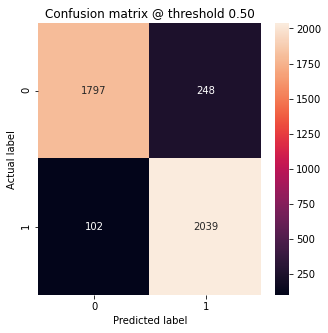

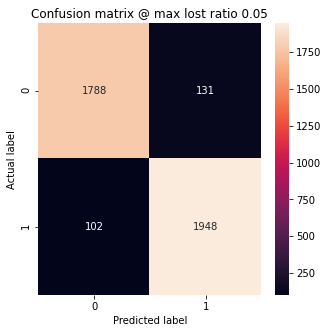

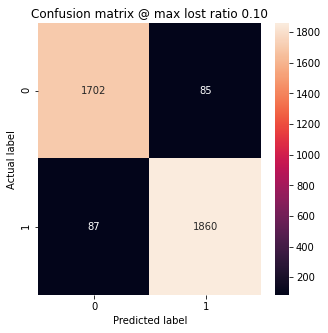

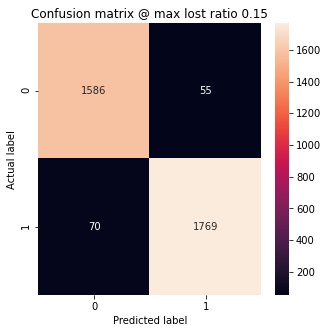

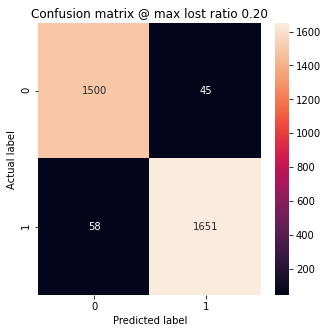

In [12]:
# -- Variables --
trial_component_display_name = 'new-factory-2021-08-03-09-01-12-training-trial'
model_path = '/home/drevital/cs_video_processor/models/new_factory_5_layers_new_dataset'
cloud_dataset = False
obstacle_dataset = '/home/drevital/obstacles_classification_datasets/new_factory/eval/obstacle'
#obstacle_dataset = 'suzuyo/eval_pairs/obstacle'
no_obstacle_dataset = '/home/drevital/obstacles_classification_datasets/new_factory/eval/no_obstacle'
#no_obstacle_dataset = 'suzuyo/eval_pairs/no_obstacle'
model_name = model_path.split('/')[-1]
thresh_csv_fname = f'model_thresholds.{model_name}.csv'
metrics_csv_fname = f'model_metrics.{model_name}.csv'
rand_images = False
num_rand_images = 10
display_negatives = False

# -- Run the Evaluation --
model = tf.keras.models.load_model(model_path)
dataset_handlers = [LocalDatasetHandler, CloudDatasetHandler]
handler = dataset_handlers[cloud_dataset](model_path,
                                          obstacle_dataset,
                                          no_obstacle_dataset,
                                          rand_images=rand_images,
                                          num_rand_images=num_rand_images,
                                          thresh_csv_fname=thresh_csv_fname,
                                          metrics_csv_fname=metrics_csv_fname)

# -- Print metrics
metrics = handler.print_model_metrics(model)
labels = np.array([0]*(handler.num_no_obstacles) + [1]*(handler.num_obstacles))

# -- Predict with the model
predictions = handler.get_predictions(model)

# -- Print confision-matrix considering the older "no decision" thresholds
threshold = 0.5
decision_margin = 0.25
lower_threshold = threshold * (1.00 - decision_margin)
upper_threshold = threshold + decision_margin * (1.00 - threshold)
handler.plot_cm_considering_thresholds(model_path,
                                       labels,
                                       predictions,
                                       lower_threshold,
                                       upper_threshold,
                                       threshold=threshold)

# Find optimal lower, upper thresholds per given max limit of "not decided" ("lost") predictions
max_lost_ratios = [0.05, 0.1, 0.15, 0.20]
print()
for max_lost_ratio in max_lost_ratios:
    print()
    lower_threshold, upper_threshold = handler.find_thresholds(predictions,
                                                               max_lost_ratio=max_lost_ratio)
    print(f'threshold: {lower_threshold}, {upper_threshold}')
    # Print confusion-matrix after using recommended thresholds
    handler.plot_cm_considering_thresholds(model_path,
                                           labels,
                                           predictions,
                                           lower_threshold,
                                           upper_threshold,
                                           max_lost_ratio=max_lost_ratio,
                                           threshold=0.5,
                                           print_to_csv=True)
    print()
    
# Retrieve model's metrics from SageMaker and write them to the handler's .csv file
handler.write_metrics_to_csv(trial_component_display_name)
del handler